#Cassava Leaf Disease Classification Project#

##Part 1: Import Packages and the Dataset##

####Import Packages###

In [42]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from google.colab import files
import pandas as pd
import io
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from google.colab import drive
import json
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import random
import tensorflow as tf
import cv2
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from sklearn.model_selection import train_test_split
import re
from functools import partial
import keras
from keras.layers import Dense, Dropout, Input, MaxPooling2D, ZeroPadding2D, Conv2D, Flatten, BatchNormalization
from keras.models import Sequential, Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras import regularizers

from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from zipfile import ZipFile
import time
from datetime import timedelta
from io import BytesIO

# Image manipulation.
import PIL.Image

import pickle
import os

import random
from keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np



###Mount the Drive###

In [43]:
import zipfile
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [44]:
f = open('/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/label_num_to_disease_map.json')
label_name = json.load(f)
label_name

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

###Load the tfrecords###

***Define Some Important Variables***
* Batch_Size: 32
* Labels: 5 different labels in total 
* tf.data.AUTOTUNE: promp the tf.data runtime to tune the value dynamically at runtime. 
* train_path: the path of training dataset directory
* test_path: the path of testing dataset directory
* Image_Size: 512*512

In [45]:
Batch_Size = 128
labels = list(label_name.keys())
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_path = '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train*.tfrec'
test_path = '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/test_tfrecords/ld_test*.tfrec'
Image_Size_Original = [512, 512]
image_size = 224

In [46]:
print(labels)

['0', '1', '2', '3', '4']


***Preprocess the Image***
* Decode a JPEG-encoded image to a uint8 tensor.
* Divide by 255 to get 0-1 representation 

In [47]:
def preprocess_img(img):
  img_decode = tf.image.decode_jpeg(img, channels = 3)
  img_255 = tf.cast(img_decode, tf.float32)/255.0
  img_res = tf.reshape(img_255, [*Image_Size_Original,3])
  img_resize = tf.image.resize(img_res, [image_size,image_size])
  return img_resize

***Read the tfrecord***

In [48]:
def read_tfrecord(example, labeled):
  tfrecord_format = {"image":tf.io.FixedLenFeature([], tf.string),
                     "target":tf.io.FixedLenFeature([], tf.int64),
                     } if labeled else {
                     "image": tf.io.FixedLenFeature([], tf.string),
                     "image_name": tf.io.FixedLenFeature([], tf.string)
                     }
  example = tf.io.parse_single_example(example, tfrecord_format)
  
  img_res = preprocess_img(example['image'])
  
  if labeled:
    label = tf.cast(example['target'], tf.int32)
    return img_res, label
  else: 
    id = example['image_name']
    return img_res, id

***Load the dataset***

In [49]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

###Splitting Strategy###

In [50]:
train_list = tf.io.gfile.glob(train_path)
test_list = tf.io.gfile.glob(test_path)
train_list, test_list

(['/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train00-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train01-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train02-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train03-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train04-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train05-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train06-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train07-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train08-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfre

In [51]:
df_training, df_validation = train_test_split(train_list,
                                              test_size=0.1, random_state=42)
df_testing = tf.io.gfile.glob(test_list)

In [52]:
len(df_training), len(df_validation), len(df_testing)

(14, 2, 1)

In [53]:
df_training, df_validation, df_testing

(['/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train05-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train14-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train13-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train11-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train08-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train09-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train02-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train15-1327.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train04-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfre

###Image Augmentation###

In [54]:
def train_augmentation(image, label):
    # image_augmentation 
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_crop(image,[image_size, image_size, 3])
    image = tf.image.random_brightness(image, max_delta = 0.5)
    image = tf.image.random_saturation(image, lower = 5, upper = 10)
    image = tf.image.random_contrast(image, 0.2, 0.5)
    image = tf.image.random_jpeg_quality(image, 75, 95)
    return image, label

###Load the dataset###

* repeat: repeats this dataset so each original value is seen infinitely. 
* shuffle: randomly shuffles the elements of this dataet. 
* prefetch: allows later elements to be prepared while the current element is being processed.

In [55]:
def get_training_dataset():
    df_train = load_dataset(df_training, labeled=True)  
    df_train = df_train.map(train_augmentation, num_parallel_calls=AUTOTUNE)  
    df_train = df_train.repeat()
    df_train = df_train.shuffle(2048)
    df_train = df_train.batch(Batch_Size)
    df_train = df_train.prefetch(AUTOTUNE) 
    return df_train

In [56]:
def get_validation_dataset(ordered=False):
    df_valid = load_dataset(df_validation, labeled=True, ordered=ordered) 
    df_valid = df_valid.batch(Batch_Size)
    #df_valid = df_valid.cache()
    df_valid = df_valid.prefetch(AUTOTUNE)
    return df_valid

In [57]:
def get_test_dataset(ordered=False):
    df_test = load_dataset(df_testing, labeled=False, ordered=ordered)
    df_test = df_test.batch(Batch_Size)
    df_test = df_test.prefetch(AUTOTUNE)
    return df_test

In [58]:
def counting(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [59]:
num_training = counting(df_training)
num_valid = counting(df_validation)
num_test = counting(df_testing)

print('This Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    num_training, num_valid, num_test))

This Dataset: 18721 training images, 2676 validation images, 1 (unlabeled) test images


In [60]:
df_train = get_training_dataset()
df_valid = get_validation_dataset()
df_test = get_test_dataset()

In [61]:
df_train, df_valid, df_test

(<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>)

In [62]:
print("Training dataset:")
for image, label in df_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
    print("Training dataset labels:", label.numpy())
print("Validation dataset:")
for image, label in df_valid.take(3):
    print(image.numpy().shape, label.numpy().shape)
    print("Validation dataset labels:", label.numpy())
print("Test dataset:")
for image, idnum in df_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
    print("Test data IDs:", idnum.numpy().astype('U')) 

Training dataset:
(128, 224, 224, 3) (128,)
Training dataset labels: [4 3 3 3 3 3 3 2 3 1 3 3 3 3 3 3 3 3 3 0 4 3 2 3 3 3 3 1 4 4 3 2 4 3 3 3 1
 4 4 3 3 3 1 2 3 2 3 1 2 2 4 3 1 1 0 3 3 4 3 3 3 1 1 1 0 2 3 3 3 3 3 3 3 3
 3 3 3 2 3 2 3 3 3 3 4 4 3 4 3 2 1 3 3 3 3 3 3 2 4 2 3 4 3 3 3 3 3 3 3 3 3
 3 3 3 4 2 0 3 2 3 1 3 3 3 1 2 1 4]
(128, 224, 224, 3) (128,)
Training dataset labels: [3 3 3 3 3 4 2 3 3 3 2 2 4 3 3 2 3 4 3 3 3 3 4 4 3 3 3 3 4 3 2 3 1 1 4 4 3
 3 4 3 1 3 3 2 4 2 3 3 4 3 3 0 3 3 1 3 3 3 1 2 3 2 3 3 3 3 3 3 3 1 3 3 3 2
 3 3 3 3 3 3 0 1 3 2 3 3 3 2 3 3 0 3 1 3 3 3 2 2 3 1 1 3 1 1 3 3 3 0 3 3 4
 1 3 0 3 1 3 2 1 3 3 3 4 3 4 3 3 3]
(128, 224, 224, 3) (128,)
Training dataset labels: [3 4 4 2 1 1 3 0 2 3 3 3 3 0 3 3 3 3 2 1 3 2 3 2 3 4 3 3 3 3 1 2 3 4 3 4 4
 0 3 2 3 3 3 3 3 3 3 1 0 3 1 2 3 3 2 3 3 3 3 3 3 0 1 4 3 3 3 4 3 4 3 4 3 3
 0 3 3 3 3 3 3 3 3 1 3 3 4 3 3 4 1 3 2 2 3 1 3 3 1 3 3 3 1 2 1 3 3 3 4 4 1
 3 3 2 3 2 3 2 0 3 3 3 3 3 3 3 3 3]
Validation dataset:
(128, 224, 224, 3) (128,)


##Part 4: Model##

###InceptionV3: 2nd Post###

In [67]:
def make_basemodel_V3():
  base_model = tf.keras.applications.InceptionV3(input_shape=(image_size,image_size,3),
                                               include_top=False,
                                               weights='imagenet')
  for layer in base_model.layers:
    layer.trainble = False
  return base_model

base_model_V3 = make_basemodel_V3()
# base_model_V3.summary()

In [69]:
def make_headmodel_V3(base_model):
  head = base_model.output

  head = tf.keras.layers.GlobalMaxPooling2D()(head)

  head = Flatten()(head)
  head = Dense(64, activation = "relu", kernel_regularizer = tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(head)
  head = Dropout(0.5)(head)

  head = tf.keras.layers.Dense(5, activation = "softmax")(head)
  model = Model(inputs=base_model.input, outputs=head)
  return model

model_V3 = make_headmodel_V3(base_model_V3)
# model_V3.summary()

In [70]:
opt = keras.optimizers.Nadam(learning_rate = 1e-5)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=50, mode='max',restore_best_weights=True)
model_V3.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Batch_Size = 256
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_V3 = model_V3.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=200, callbacks=[early_stopping])

Epoch 1/200
73/73 [==============================] - 74s 617ms/step - loss: 39.0227 - accuracy: 0.3078 - val_loss: 37.1686 - val_accuracy: 0.6062
Epoch 2/200
73/73 [==============================] - 44s 601ms/step - loss: 37.1383 - accuracy: 0.5513 - val_loss: 36.5617 - val_accuracy: 0.6109
Epoch 3/200
73/73 [==============================] - 44s 610ms/step - loss: 36.5113 - accuracy: 0.5938 - val_loss: 35.9815 - val_accuracy: 0.6172
Epoch 4/200
73/73 [==============================] - 42s 580ms/step - loss: 35.9225 - accuracy: 0.6053 - val_loss: 35.3863 - val_accuracy: 0.6242
Epoch 5/200
73/73 [==============================] - 41s 558ms/step - loss: 35.3333 - accuracy: 0.6096 - val_loss: 34.7842 - val_accuracy: 0.6352
Epoch 6/200
73/73 [==============================] - 41s 559ms/step - loss: 34.7233 - accuracy: 0.6182 - val_loss: 34.1711 - val_accuracy: 0.6422
Epoch 7/200
73/73 [==============================] - 41s 557ms/step - loss: 34.0895 - accuracy: 0.6293 - val_loss: 33.5550 -

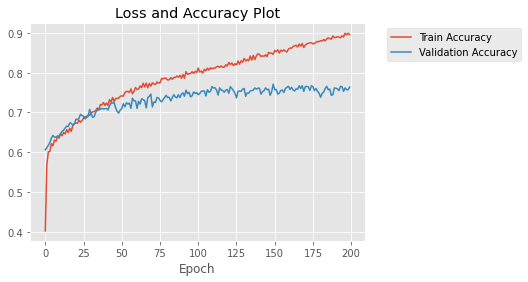

In [71]:
N = 200
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_V3.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_V3.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

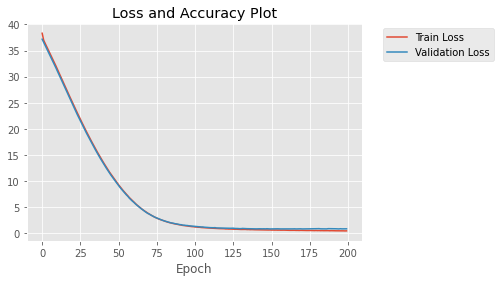

In [72]:
N = 200
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_V3.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_V3.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


In [73]:
for layer in base_model_V3.layers:
  layer.trainbale = True

# for layer in model_V3.layers:
#   print(layer, layer.trainable)

In [75]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr = 1e-7, cooldown=2)
opt = keras.optimizers.Nadam(learning_rate = 1e-6)
model_V3.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [76]:
Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_V3F = model_V3.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=30,
                    callbacks=[rlrop, early_stopping])

Epoch 1/30
146/146 [==============================] - 112s 584ms/step - loss: 0.5826 - accuracy: 0.8588 - val_loss: 0.8063 - val_accuracy: 0.7594
Epoch 2/30
146/146 [==============================] - 84s 578ms/step - loss: 0.5798 - accuracy: 0.8545 - val_loss: 0.8098 - val_accuracy: 0.7574
Epoch 3/30
146/146 [==============================] - 85s 582ms/step - loss: 0.5784 - accuracy: 0.8584 - val_loss: 0.8111 - val_accuracy: 0.7559
Epoch 4/30
146/146 [==============================] - 83s 569ms/step - loss: 0.5912 - accuracy: 0.8505 - val_loss: 0.8139 - val_accuracy: 0.7555
Epoch 5/30
146/146 [==============================] - 88s 601ms/step - loss: 0.5719 - accuracy: 0.8591 - val_loss: 0.8168 - val_accuracy: 0.7559
Epoch 6/30
146/146 [==============================] - 85s 581ms/step - loss: 0.5797 - accuracy: 0.8548 - val_loss: 0.8198 - val_accuracy: 0.7535
Epoch 7/30
146/146 [==============================] - 85s 581ms/step - loss: 0.5744 - accuracy: 0.8559 - val_loss: 0.8159 - val_a

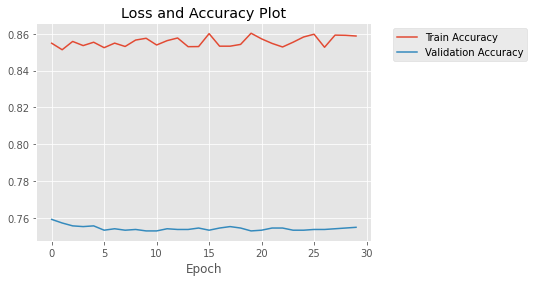

In [77]:
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_V3F.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_V3F.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


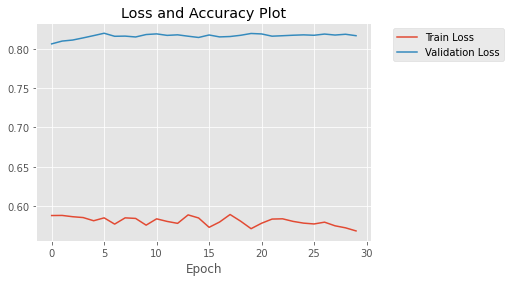

In [78]:
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_V3F.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_V3F.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


### ResNet50: 2nd Post

In [155]:
from tensorflow.keras.applications import InceptionResNetV2
def make_basemodel_RS():
    base_resnet = tf.keras.applications.ResNet50(include_top = False, 
                        input_shape=(image_size, image_size, 3),
                        weights="imagenet")
    
    for layer in base_resnet.layers:
      layer.trainble = False
  
    return base_resnet

base_model_RS = make_basemodel_RS()

In [156]:
def make_headmodel_RS(base_model):
  head = base_model.output

  head = tf.keras.layers.GlobalMaxPooling2D()(head) 

  head = tf.keras.layers.Dense(256, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(head)
  head = Dropout(0.6)(head)

  head = tf.keras.layers.Dense(5, activation = "softmax")(head)
  model = Model(inputs=base_model.input, outputs=head)
  return model

model_RS = make_headmodel_RS(base_model_RS)

In [157]:
opt = keras.optimizers.Adam(1e-4)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr = 0.00001, cooldown=2)

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4, min_lr=0.00001)
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50, restore_best_weights = True)
model_RS.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [158]:
Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_RS = model_RS.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=150, callbacks = [es, rlrop])

Epoch 1/150
125/125 [==============================] - 100s 712ms/step - loss: 139.6077 - accuracy: 0.4749 - val_loss: 122.0753 - val_accuracy: 0.1103
Epoch 2/150
125/125 [==============================] - 88s 707ms/step - loss: 110.1619 - accuracy: 0.6150 - val_loss: 89.8007 - val_accuracy: 0.5223
Epoch 3/150
125/125 [==============================] - 89s 709ms/step - loss: 82.9428 - accuracy: 0.6426 - val_loss: 65.4726 - val_accuracy: 0.1446
Epoch 4/150
125/125 [==============================] - 88s 707ms/step - loss: 59.3561 - accuracy: 0.6722 - val_loss: 45.5749 - val_accuracy: 0.1406
Epoch 5/150
125/125 [==============================] - 89s 710ms/step - loss: 40.6097 - accuracy: 0.6848 - val_loss: 29.8675 - val_accuracy: 0.6082
Epoch 6/150
125/125 [==============================] - 88s 706ms/step - loss: 26.6924 - accuracy: 0.7024 - val_loss: 19.0189 - val_accuracy: 0.6824
Epoch 7/150
125/125 [==============================] - 89s 711ms/step - loss: 16.9856 - accuracy: 0.7204 - v

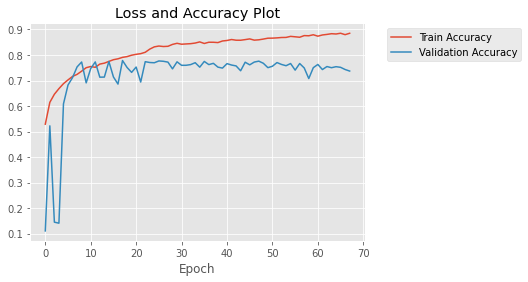

In [165]:
N = 68
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_RS.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_RS.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

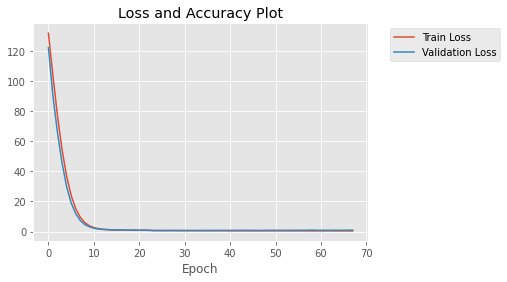

In [166]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_RS.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_RS.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [159]:
for layer in model_RS.layers:
  layer.trainable = True

for layer in model_RS.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f36de227ad0> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f36d9557e10> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f36d9548710> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f36de57cf10> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f36de55b5d0> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f36d9548c90> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f36de6fc610> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f36d9548c50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f36d95661d0> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f36d956b250> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f36d95595d0> True
<tensorflow.python.keras.layers.normaliz

In [160]:
opt = keras.optimizers.Adam(1e-5)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr = 0.00001, cooldown=2)
model_RS.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [161]:
Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_RSF = model_RS.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=30)

Epoch 1/30
125/125 [==============================] - 99s 710ms/step - loss: 0.7183 - accuracy: 0.8060 - val_loss: 0.7647 - val_accuracy: 0.7742
Epoch 2/30
125/125 [==============================] - 88s 706ms/step - loss: 0.6570 - accuracy: 0.8133 - val_loss: 0.7585 - val_accuracy: 0.7719
Epoch 3/30
125/125 [==============================] - 88s 708ms/step - loss: 0.6430 - accuracy: 0.8137 - val_loss: 0.8025 - val_accuracy: 0.7429
Epoch 4/30
125/125 [==============================] - 88s 706ms/step - loss: 0.6361 - accuracy: 0.8136 - val_loss: 0.7498 - val_accuracy: 0.7723
Epoch 5/30
125/125 [==============================] - 88s 707ms/step - loss: 0.6256 - accuracy: 0.8197 - val_loss: 0.7649 - val_accuracy: 0.7519
Epoch 6/30
125/125 [==============================] - 88s 707ms/step - loss: 0.6275 - accuracy: 0.8150 - val_loss: 0.7768 - val_accuracy: 0.7546
Epoch 7/30
125/125 [==============================] - 89s 709ms/step - loss: 0.6139 - accuracy: 0.8224 - val_loss: 0.7550 - val_ac

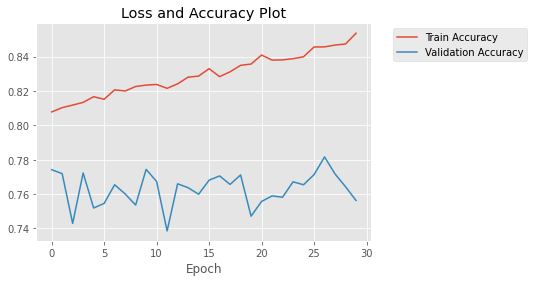

In [163]:
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_RSF.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_RSF.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

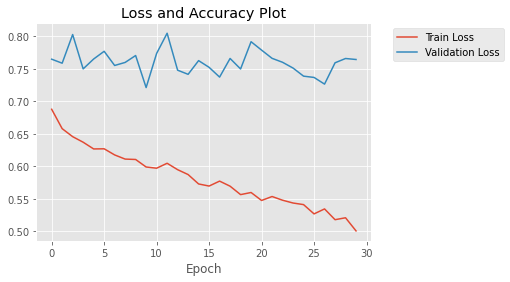

In [164]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_RSF.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_RSF.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

###InceptionV3: 0.76###

In [28]:
def make_basemodel_V3():
  base_model = tf.keras.applications.InceptionV3(input_shape=(image_size,image_size,3),
                                               include_top=False,
                                               weights='imagenet')
  for layer in base_model.layers:
    layer.trainble = False
  return base_model

base_model_V3 = make_basemodel_V3()

In [25]:
def make_headmodel_V3(base_model):
  head = base_model.output

  head = tf.keras.layers.GlobalMaxPooling2D()(head)

  head = Flatten()(head)
  head = Dense(64, activation = "relu", kernel_regularizer = tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(head)
  head = Dropout(0.5)(head)

  head = tf.keras.layers.Dense(5, activation = "softmax")(head)
  model = Model(inputs=base_model.input, outputs=head)
  return model

model_V3 = make_headmodel_V3(base_model_V3)
# model_V3.summary()

In [27]:
opt = keras.optimizers.Nadam(learning_rate = 1e-5)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=50, mode='max',restore_best_weights=True)
model_V3.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Batch_Size =128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_V3 = model_V3.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=200, callbacks=[early_stopping])

Epoch 1/200
125/125 [==============================] - 131s 710ms/step - loss: 38.6361 - accuracy: 0.3375 - val_loss: 36.6195 - val_accuracy: 0.6119
Epoch 2/200
125/125 [==============================] - 81s 651ms/step - loss: 36.4536 - accuracy: 0.5980 - val_loss: 35.6261 - val_accuracy: 0.6113
Epoch 3/200
125/125 [==============================] - 82s 656ms/step - loss: 35.4281 - accuracy: 0.6088 - val_loss: 34.5534 - val_accuracy: 0.6128
Epoch 4/200
125/125 [==============================] - 82s 661ms/step - loss: 34.3497 - accuracy: 0.6125 - val_loss: 33.4526 - val_accuracy: 0.6206
Epoch 5/200
125/125 [==============================] - 79s 630ms/step - loss: 33.2435 - accuracy: 0.6230 - val_loss: 32.3334 - val_accuracy: 0.6328
Epoch 6/200
125/125 [==============================] - 79s 631ms/step - loss: 32.1270 - accuracy: 0.6266 - val_loss: 31.2076 - val_accuracy: 0.6486
Epoch 7/200
125/125 [==============================] - 79s 631ms/step - loss: 30.9909 - accuracy: 0.6380 - val_

KeyboardInterrupt: ignored

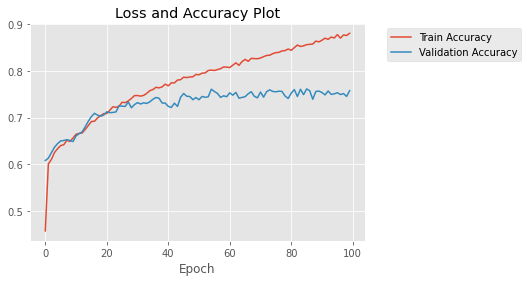

In [ ]:
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_V3.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_V3.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

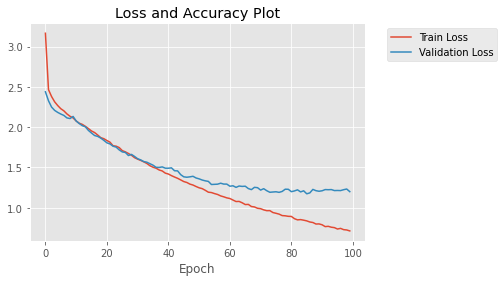

In [ ]:
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_V3.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_V3.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


In [ ]:
for layer in base_model_V3.layers:
  layer.trainbale = True

# for layer in model_V3.layers:
#   print(layer, layer.trainable)

In [ ]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr = 1e-7, cooldown=2)
opt = keras.optimizers.Nadam(learning_rate = 1e-6)
early_stopping = EarlyStopping(monitor = 'val_accuracy', verbose = 1, patience = 15, mode ='max', restore_best_weights = True)
model_V3.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_V3F = model_V3.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=30,
                    callbacks=[rlrop, early_stopping])

Epoch 1/20
125/125 [==============================] - 95s 582ms/step - loss: 0.7103 - accuracy: 0.8838 - val_loss: 1.2020 - val_accuracy: 0.7571
Epoch 2/20
125/125 [==============================] - 72s 576ms/step - loss: 0.7004 - accuracy: 0.8822 - val_loss: 1.2034 - val_accuracy: 0.7584
Epoch 3/20
125/125 [==============================] - 72s 575ms/step - loss: 0.7066 - accuracy: 0.8847 - val_loss: 1.2029 - val_accuracy: 0.7591
Epoch 4/20
125/125 [==============================] - 72s 580ms/step - loss: 0.7040 - accuracy: 0.8829 - val_loss: 1.2007 - val_accuracy: 0.7588
Epoch 5/20
125/125 [==============================] - 72s 578ms/step - loss: 0.6875 - accuracy: 0.8885 - val_loss: 1.2023 - val_accuracy: 0.7591
Epoch 6/20
125/125 [==============================] - 72s 578ms/step - loss: 0.7079 - accuracy: 0.8844 - val_loss: 1.2011 - val_accuracy: 0.7588
Epoch 7/20
125/125 [==============================] - 72s 573ms/step - loss: 0.7178 - accuracy: 0.8758 - val_loss: 1.2029 - val_ac

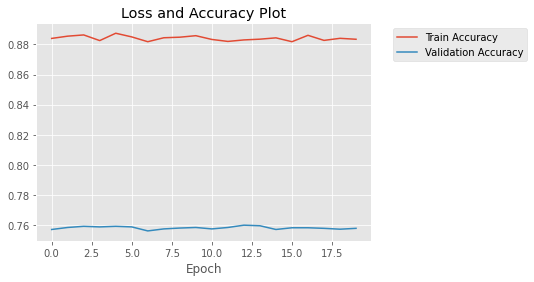

In [ ]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_V3F.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_V3F.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


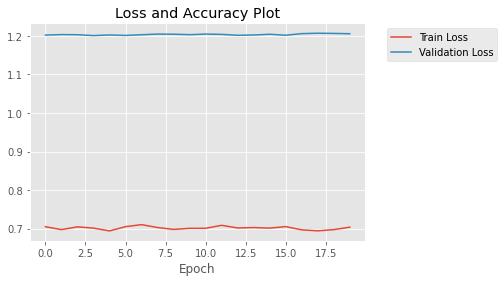

In [ ]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_V3F.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_V3F.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


###VGG16 (Try)###

In [112]:
from keras.applications.vgg16 import VGG16

def create_vgg(dropout_rate=0.2):
  base_model = VGG16(weights = 'imagenet', include_top = False, input_shape=(image_size, image_size,3))
  for layer in base_model.layers[:5]:
    layer.trainable = False

  model = base_model.output
  model = Flatten()(model)
  model = Dense(256, activation='relu')(model)
  model = Dropout(0.5)(model)

  model = Dense(128, activation='relu')(model)
  model = Dropout(0.5)(model)

  out = Dense(5, activation='softmax')(model)
  
  model = Model(inputs = base_model.input, outputs = out)
  return model

model_vgg = create_vgg()

In [113]:
opt = keras.optimizers.Nadam(learning_rate = 1e-5)
model_vgg.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [115]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50, restore_best_weights = True)

In [116]:
Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_IR = model_vgg.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=300, callbacks = [es])

Epoch 1/300
125/125 [==============================] - 86s 620ms/step - loss: 1.5953 - accuracy: 0.3883 - val_loss: 1.1194 - val_accuracy: 0.6117
Epoch 2/300
125/125 [==============================] - 78s 621ms/step - loss: 1.2209 - accuracy: 0.5686 - val_loss: 1.0463 - val_accuracy: 0.6237
Epoch 3/300
125/125 [==============================] - 78s 625ms/step - loss: 1.1543 - accuracy: 0.5966 - val_loss: 1.0538 - val_accuracy: 0.6522
Epoch 4/300
125/125 [==============================] - 78s 623ms/step - loss: 1.1148 - accuracy: 0.6035 - val_loss: 0.9785 - val_accuracy: 0.6542
Epoch 5/300
125/125 [==============================] - 78s 622ms/step - loss: 1.0726 - accuracy: 0.6237 - val_loss: 0.9766 - val_accuracy: 0.6612
Epoch 6/300
125/125 [==============================] - 77s 619ms/step - loss: 1.0446 - accuracy: 0.6327 - val_loss: 0.9998 - val_accuracy: 0.6751
Epoch 7/300
125/125 [==============================] - 78s 623ms/step - loss: 1.0197 - accuracy: 0.6326 - val_loss: 0.9303 -

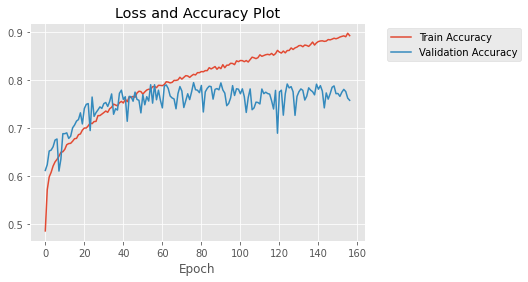

In [118]:
N = 157
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_IR.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

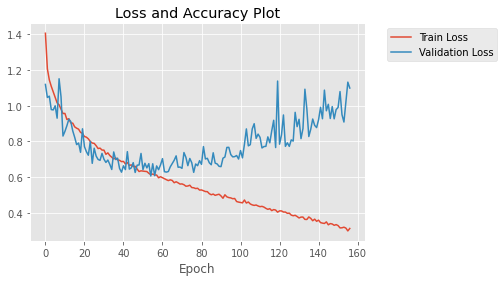

In [119]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_IR.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [120]:
for layer in model_vgg.layers:
  layer.trainable = True

for layer in model_vgg.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f36dbcc8ad0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f36dbcc8b50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f36dbce9250> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f36dbce9a10> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f36dbcc8450> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f36dbcd5090> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f36dbcc2710> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f36dbcffe90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f36deeab610> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f36dbcf9b10> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f36dbcf9c10> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f36dbcc2

In [121]:
opt = keras.optimizers.Nadam(learning_rate = 1e-6)
model_vgg.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_IRF = model_vgg.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=20)

Epoch 1/20
125/125 [==============================] - 117s 874ms/step - loss: 0.5166 - accuracy: 0.8174 - val_loss: 0.6785 - val_accuracy: 0.7710
Epoch 2/20
125/125 [==============================] - 111s 888ms/step - loss: 0.5111 - accuracy: 0.8225 - val_loss: 0.6735 - val_accuracy: 0.7736
Epoch 3/20
125/125 [==============================] - 111s 891ms/step - loss: 0.5120 - accuracy: 0.8226 - val_loss: 0.6825 - val_accuracy: 0.7732
Epoch 4/20
125/125 [==============================] - 110s 881ms/step - loss: 0.5029 - accuracy: 0.8235 - val_loss: 0.7047 - val_accuracy: 0.7700
Epoch 5/20
125/125 [==============================] - 111s 886ms/step - loss: 0.4999 - accuracy: 0.8242 - val_loss: 0.6838 - val_accuracy: 0.7753
Epoch 6/20
125/125 [==============================] - 110s 883ms/step - loss: 0.4932 - accuracy: 0.8269 - val_loss: 0.6952 - val_accuracy: 0.7694
Epoch 7/20
125/125 [==============================] - 110s 884ms/step - loss: 0.4973 - accuracy: 0.8240 - val_loss: 0.6734 -

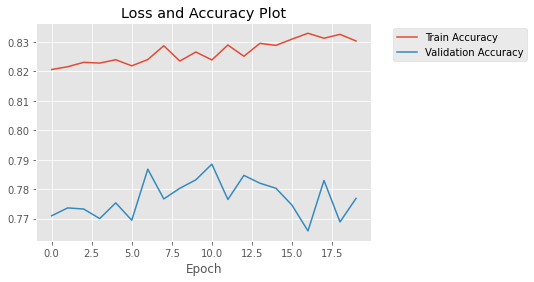

In [123]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IRF.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_IRF.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

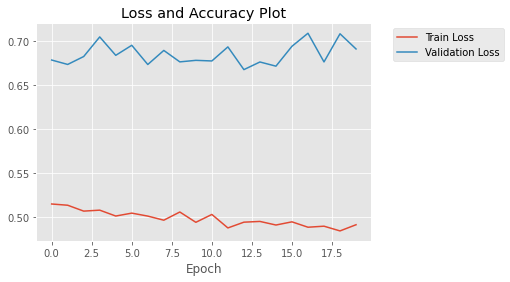

In [124]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IRF.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_IRF.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [ ]:
# save model
from keras.models import load_model
import os
def save_model(model, name):
  model_name = '{}.h5'.format(name)
  save_dir = os.path.join(os.getcwd(), 'saved_models')
  
  # Save model and weights
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  model_path = os.path.join(save_dir, model_name)
  model.save(model_path)
  print('Saved trained model at %s ' % model_path)

In [ ]:
save_model(model_vgg, 'VGG_model')

###InceptionV3: 0.75###

In [ ]:
def make_basemodel_1():
  base_model = tf.keras.applications.InceptionV3(input_shape=(image_size,image_size,3),
                                               include_top=False,
                                               weights='imagenet')
  for layer in base_model.layers:
    layer.trainble = False
  return base_model

base_model = make_basemodel_1()

In [ ]:
def make_headmodel_1(base_model):
  head = base_model.output

  head = tf.keras.layers.GlobalMaxPooling2D()(head)
  head = tf.keras.layers.BatchNormalization()(head)
  head = Dropout(0.3)(head)

  head = Flatten()(head)
  head = Dense(256, activation = "relu", kernel_regularizer = 'l2')(head)
  head = Dropout(0.5)(head)

  head = tf.keras.layers.Dense(5, activation = "softmax")(head)
  model = Model(inputs=base_model.input, outputs=head)
  return model

model = make_headmodel_1(base_model)


In [ ]:
opt = keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = True)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history = model.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=30)

Epoch 1/30
125/125 [==============================] - 85s 578ms/step - loss: 6.4754 - accuracy: 0.4188 - val_loss: 5.3458 - val_accuracy: 0.6663
Epoch 2/30
125/125 [==============================] - 71s 566ms/step - loss: 5.4371 - accuracy: 0.6138 - val_loss: 4.8430 - val_accuracy: 0.6972
Epoch 3/30
125/125 [==============================] - 71s 565ms/step - loss: 4.9488 - accuracy: 0.6435 - val_loss: 4.5454 - val_accuracy: 0.7136
Epoch 4/30
125/125 [==============================] - 70s 562ms/step - loss: 4.4949 - accuracy: 0.6782 - val_loss: 4.1877 - val_accuracy: 0.7012
Epoch 5/30
125/125 [==============================] - 71s 572ms/step - loss: 4.1148 - accuracy: 0.7047 - val_loss: 3.8626 - val_accuracy: 0.7111
Epoch 6/30
125/125 [==============================] - 71s 567ms/step - loss: 3.7818 - accuracy: 0.7202 - val_loss: 3.5173 - val_accuracy: 0.7268
Epoch 7/30
125/125 [==============================] - 71s 568ms/step - loss: 3.4646 - accuracy: 0.7307 - val_loss: 3.2895 - val_ac

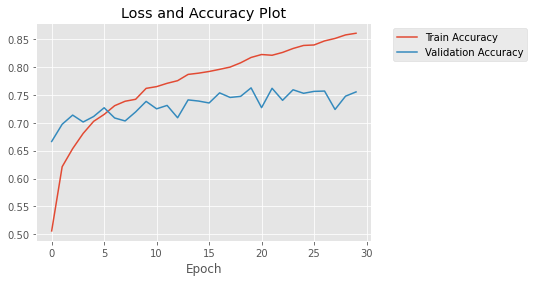

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

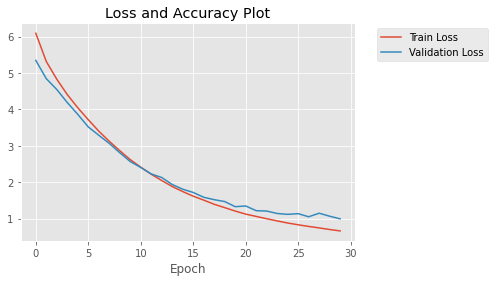

In [ ]:
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


In [ ]:
base_model.trainable = True
for layer in model.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f27a4b06ed0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f27a4b06890> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f26d3998a10> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f26cf18bd90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f27a4b29f50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f27a4b24390> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f27a4b13d90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f27a4b2e390> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f27a4afedd0> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f27a4b26690> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f27a4b2e190> True
<tensorflow.python.keras.layers.convolutiona

In [ ]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr = 0.000001, cooldown=2)
opt = keras.optimizers.Adam(learning_rate = 0.00001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_t = model.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=20,
                    callbacks=[rlrop])

Epoch 1/20
125/125 [==============================] - 76s 564ms/step - loss: 0.6017 - accuracy: 0.8737 - val_loss: 1.0332 - val_accuracy: 0.7523
Epoch 2/20
125/125 [==============================] - 69s 556ms/step - loss: 0.5954 - accuracy: 0.8715 - val_loss: 1.0243 - val_accuracy: 0.7502
Epoch 3/20
125/125 [==============================] - 69s 555ms/step - loss: 0.5694 - accuracy: 0.8748 - val_loss: 1.0425 - val_accuracy: 0.7494
Epoch 4/20
125/125 [==============================] - 69s 556ms/step - loss: 0.5516 - accuracy: 0.8796 - val_loss: 1.0447 - val_accuracy: 0.7483
Epoch 5/20
125/125 [==============================] - 70s 561ms/step - loss: 0.5332 - accuracy: 0.8842 - val_loss: 1.0431 - val_accuracy: 0.7462
Epoch 6/20
125/125 [==============================] - 70s 558ms/step - loss: 0.5164 - accuracy: 0.8886 - val_loss: 1.0372 - val_accuracy: 0.7489
Epoch 7/20
125/125 [==============================] - 69s 556ms/step - loss: 0.5178 - accuracy: 0.8867 - val_loss: 1.0372 - val_ac

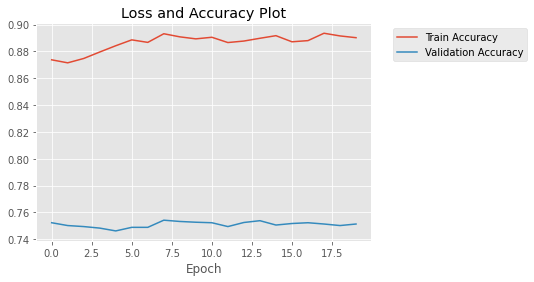

In [ ]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_t.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_t.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

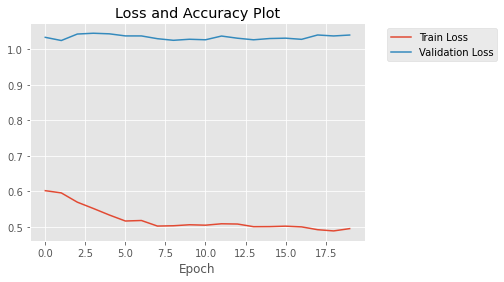

In [ ]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_t.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_t.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

###EfficientNet###

In [ ]:
from keras import backend as K  
  
K.clear_session()

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
def make_basemodel_IR2():
    base_model = InceptionResNetV2(input_shape = (image_size,image_size,3), 
                                include_top = False, weights = 'imagenet')
    
    for layer in base_model.layers:
      layer.trainble = False
  
    return base_model

base_model_IR2 = make_basemodel_IR2()

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
def make_headmodel_IR2(base_model):
  head = base_model.output

  head = tf.keras.layers.GlobalAveragePooling2D()(head) 

  # head = tf.keras.layers.Dense(64, activation = "relu")(head)
  head = Dropout(0.5)(head)

  head = tf.keras.layers.Dense(5, activation = "softmax")(head)
  model = Model(inputs=base_model.input, outputs=head)
  return model

model_IR2 = make_headmodel_IR2(base_model_IR2)


In [ ]:
opt = keras.optimizers.Nadam(1e-4)
model_IR2.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_IR2 = model_IR2.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=30)

Epoch 1/30


KeyboardInterrupt: ignored

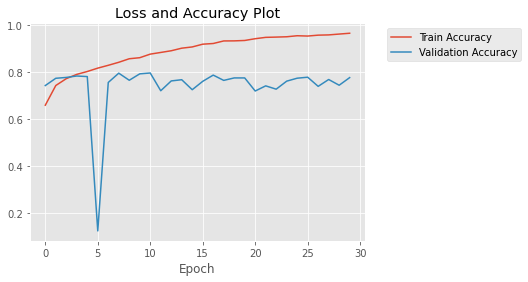

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR2.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_IR2.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

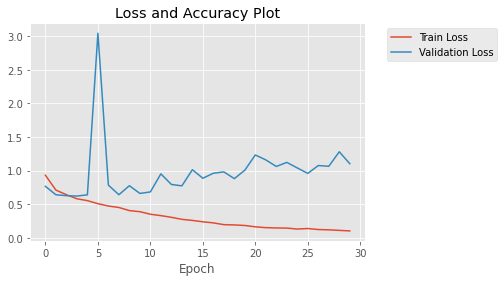

In [ ]:
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR2.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_IR2.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [ ]:
# for layer in model.layers[-20:]:
#   if not isinstance(layer, layers.BatchNormalization):
#     layer.trainable = True
for layer in base_model_IR2.layers:
  layer.trainbale = True

opt = keras.optimizers.Nadam(1e-6)
model_IR2.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_IR2F = model_IR2.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=10)

Epoch 1/10
125/125 [==============================] - 152s 821ms/step - loss: 0.0898 - accuracy: 0.9704 - val_loss: 1.0647 - val_accuracy: 0.7757
Epoch 2/10
125/125 [==============================] - 100s 801ms/step - loss: 0.0906 - accuracy: 0.9683 - val_loss: 1.0672 - val_accuracy: 0.7761
Epoch 3/10
125/125 [==============================] - 100s 797ms/step - loss: 0.0867 - accuracy: 0.9703 - val_loss: 1.0619 - val_accuracy: 0.7744
Epoch 4/10
125/125 [==============================] - 100s 798ms/step - loss: 0.0833 - accuracy: 0.9704 - val_loss: 1.0608 - val_accuracy: 0.7763
Epoch 5/10
125/125 [==============================] - 100s 802ms/step - loss: 0.0784 - accuracy: 0.9714 - val_loss: 1.0579 - val_accuracy: 0.7772
Epoch 6/10
125/125 [==============================] - 100s 800ms/step - loss: 0.0761 - accuracy: 0.9732 - val_loss: 1.0635 - val_accuracy: 0.7776
Epoch 7/10
125/125 [==============================] - 100s 803ms/step - loss: 0.0744 - accuracy: 0.9741 - val_loss: 1.0672 -

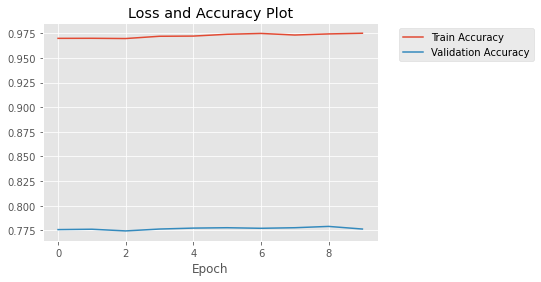

In [ ]:
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR2F.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_IR2F.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

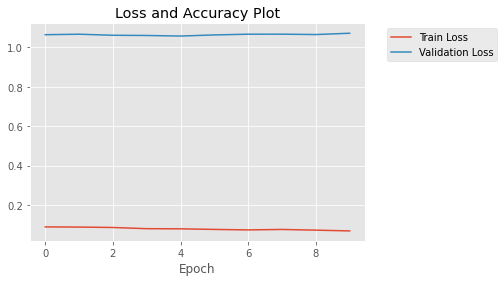

In [ ]:
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR2F.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_IR2F.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

###InceptionResnet###

In [23]:
from keras import backend as K  
  
K.clear_session()

In [24]:
from tensorflow.keras.applications import InceptionResNetV2
def make_basemodel_IR2():
    base_model = InceptionResNetV2(input_shape = (image_size,image_size,3), 
                                include_top = False, weights = 'imagenet')
    
    for layer in base_model.layers:
      layer.trainble = False
  
    return base_model

base_model_IR = make_basemodel_IR2()

219062272/219055592 [==============================] - 5s 0us/step


In [31]:
def make_headmodel_IR2(base_model):
  head = base_model.output

  head = tf.keras.layers.GlobalMaxPooling2D()(head) 
  
  head = tf.keras.layers.Dense(64, activation = "relu",kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(head)
  head = Dropout(0.5)(head)

  head = tf.keras.layers.Dense(32, activation = "relu",kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(head)
  head = Dropout(0.5)(head)

  head = tf.keras.layers.Dense(5, activation = "softmax")(head)
  model = Model(inputs=base_model.input, outputs=head)
  return model

model_IR = make_headmodel_IR2(base_model_IR)
model_IR.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [27]:
opt = keras.optimizers.Adam(1e-4)
model_IR.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [28]:
Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_IR = model_IR.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=50)

Epoch 1/50


ResourceExhaustedError: ignored

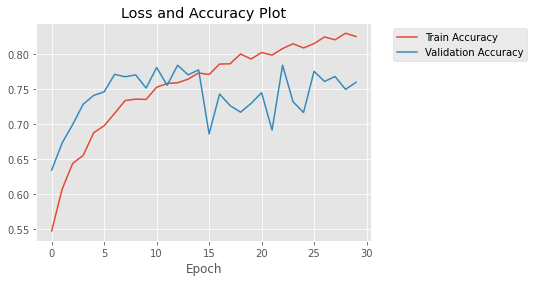

In [ ]:
N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_IR.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

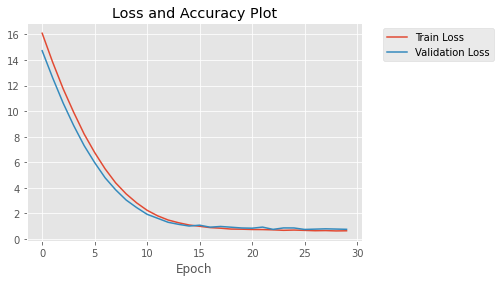

In [ ]:
N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_IR.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [ ]:
for layer in base_model_IR.layers:
  layer.trainbale = True

opt = keras.optimizers.Adam(1e-5)
model_IR.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
Batch_Size = 256
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_IR = model_IR.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=10)

Epoch 1/10
62/62 [==============================] - 103s 861ms/step - loss: 0.5940 - accuracy: 0.8430 - val_loss: 0.7601 - val_accuracy: 0.7582
Epoch 2/10
62/62 [==============================] - 51s 818ms/step - loss: 0.5711 - accuracy: 0.8495 - val_loss: 0.7672 - val_accuracy: 0.7531
Epoch 3/10
62/62 [==============================] - 51s 821ms/step - loss: 0.5636 - accuracy: 0.8517 - val_loss: 0.7696 - val_accuracy: 0.7508
Epoch 4/10
 4/62 [>.............................] - ETA: 42s - loss: 0.5509 - accuracy: 0.8491

KeyboardInterrupt: ignored

In [ ]:
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_IR.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [ ]:
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_IR.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

### ResNet50 (512, 0.5)

In [176]:
from tensorflow.keras.applications import InceptionResNetV2
def make_basemodel_RS():
    base_resnet = tf.keras.applications.ResNet50(include_top = False, 
                        input_shape=(image_size, image_size, 3),
                        weights="imagenet")
    
    for layer in base_resnet.layers:
      layer.trainble = False
  
    return base_resnet

base_model_RS1 = make_basemodel_RS()

In [177]:
def make_headmodel_RS(base_model):
  head = base_model.output

  head = tf.keras.layers.GlobalMaxPooling2D()(head) 

  head = tf.keras.layers.Dense(512, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(head)
  head = Dropout(0.7)(head)

  head = tf.keras.layers.Dense(5, activation = "softmax")(head)
  model = Model(inputs=base_model.input, outputs=head)
  return model

model_RS1 = make_headmodel_RS(base_model_RS1)

In [179]:
opt = keras.optimizers.Adam(1e-5)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr = 0.00001, cooldown=2)

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=40, restore_best_weights = True)
model_RS1.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_RS1 = model_RS1.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=150, callbacks = [es, rlrop])

Epoch 1/150
125/125 [==============================] - 99s 710ms/step - loss: 271.6612 - accuracy: 0.4784 - val_loss: 281.3361 - val_accuracy: 0.6117
Epoch 2/150
125/125 [==============================] - 88s 705ms/step - loss: 206.7689 - accuracy: 0.6035 - val_loss: 162.0901 - val_accuracy: 0.0461
Epoch 3/150
125/125 [==============================] - 88s 707ms/step - loss: 147.7372 - accuracy: 0.6413 - val_loss: 111.1854 - val_accuracy: 0.1271
Epoch 4/150
125/125 [==============================] - 88s 706ms/step - loss: 99.4537 - accuracy: 0.6700 - val_loss: 71.2484 - val_accuracy: 0.5766
Epoch 5/150
125/125 [==============================] - 89s 711ms/step - loss: 63.1220 - accuracy: 0.6864 - val_loss: 43.1471 - val_accuracy: 0.6530
Epoch 6/150
125/125 [==============================] - 88s 705ms/step - loss: 37.8722 - accuracy: 0.7140 - val_loss: 25.0136 - val_accuracy: 0.6961
Epoch 7/150
125/125 [==============================] - 88s 708ms/step - loss: 21.8659 - accuracy: 0.7226 -

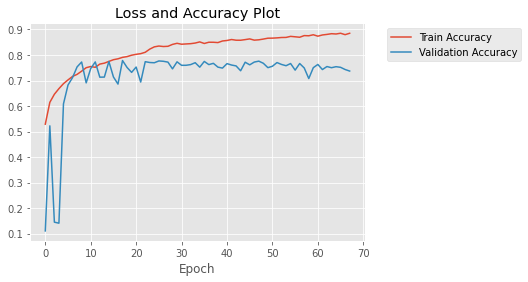

In [ ]:
N = 68
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_RS1.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_RS1.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

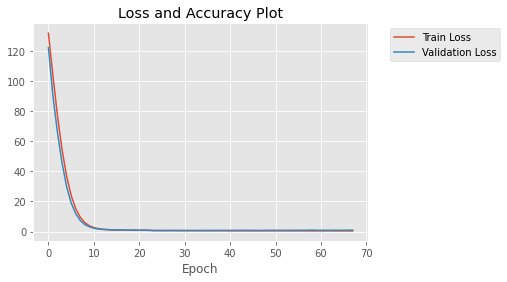

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_RS1.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_RS1.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [173]:
for layer in model_RS1.layers:
  layer.trainable = True

for layer in model_RS1.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f36d9557f50> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f36decd5bd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f36db3fd810> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f36db3dead0> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f36db43cb50> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f36db496590> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f36db4692d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f36db3eb2d0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f36db4566d0> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f36db39f7d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f36d9bb9d10> True
<tensorflow.python.keras.layers.normaliz

In [174]:
opt = keras.optimizers.Adam(1e-5)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr = 0.00001, cooldown=2)
model_RS1.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [175]:
Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_RSF1 = model_RS1.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=30)

Epoch 1/30
125/125 [==============================] - 100s 710ms/step - loss: 1.2217 - accuracy: 0.6338 - val_loss: 1.1330 - val_accuracy: 0.6625
Epoch 2/30
125/125 [==============================] - 88s 705ms/step - loss: 1.2263 - accuracy: 0.6283 - val_loss: 1.1317 - val_accuracy: 0.6601
Epoch 3/30
125/125 [==============================] - 88s 706ms/step - loss: 1.2042 - accuracy: 0.6343 - val_loss: 1.1068 - val_accuracy: 0.6635
Epoch 4/30
125/125 [==============================] - 88s 706ms/step - loss: 1.2240 - accuracy: 0.6326 - val_loss: 1.1076 - val_accuracy: 0.6677
Epoch 5/30
125/125 [==============================] - 88s 707ms/step - loss: 1.1933 - accuracy: 0.6342 - val_loss: 1.1004 - val_accuracy: 0.6723
Epoch 6/30
125/125 [==============================] - 88s 705ms/step - loss: 1.2236 - accuracy: 0.6285 - val_loss: 1.1032 - val_accuracy: 0.6755
Epoch 7/30
125/125 [==============================] - 88s 709ms/step - loss: 1.2117 - accuracy: 0.6319 - val_loss: 1.1232 - val_a

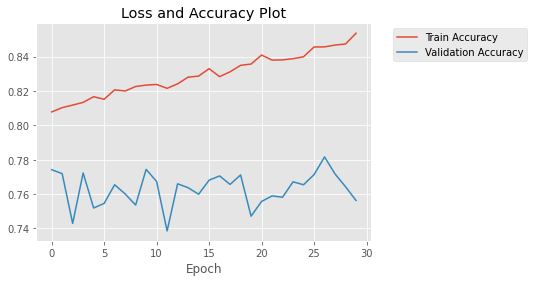

In [ ]:
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_RSF1.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_RSF1.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

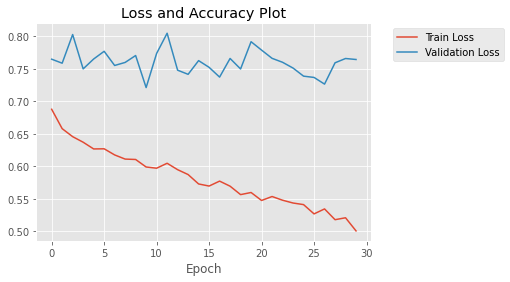

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_RSF.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_RSF.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')